In [ ]:
#https://www.machinelearningnuggets.com/how-to-generate-images-with-variational-autoencoders-vae-and-keras/
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.losses import mse
import numpy as np
from tensorflow.keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Reshape, Conv2DTranspose,BatchNormalization,LeakyReLU,Dropout
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import configparser
import pathlib
import shutil

In [ ]:


# Loading configurations
configParser = configparser.RawConfigParser()   
configFilePath = r'configuration.txt'
configParser.read(configFilePath)

insert_amd_env_vars =  int(configParser.get('COMMON', 'insert_amd_env_vars'))
HSA_OVERRIDE_GFX_VERSION =  configParser.get('COMMON', 'HSA_OVERRIDE_GFX_VERSION')
ROCM_PATH =  configParser.get('COMMON', 'ROCM_PATH')

if(insert_amd_env_vars != 0):
    os.environ["HSA_OVERRIDE_GFX_VERSION"] = HSA_OVERRIDE_GFX_VERSION
    os.environ["ROCM_PATH"] = ROCM_PATH

In [ ]:
source_dir = configParser.get('extractFaces', 'datasetPathFaces')
base_dir = configParser.get('vae', 'base_dir')
no_images_used = int(configParser.get('vae', 'no_images_used'))
batch_size = 16
img_size = 32


In [7]:
i = 0
j = 0
user_prev = ""
for root, dirs, files in os.walk(source_dir):

    if(j > no_images_used):
        break

    for file in files:
        #print(file,root)
        i = i + 1
        p_small = pathlib.Path(os.path.dirname(root + "/" + file))
        p_big = p_small.parent.absolute()
        #print(p_small)
        #print(p_big.name)
        user = p_big.name
        folderFace = base_dir + "/" + user
        #print(folderFace)
        #print(absPathFace)
        #Create Directory
        #pathlib.Path(os.path.dirname(absPathGuide)).mkdir(parents=True, exist_ok=True)
        new_file = folderFace + "/" + file
        if(user_prev != user):
            pathlib.Path(os.path.dirname(new_file)).mkdir(parents=True, exist_ok=True)
            shutil.copy2(root + "/" + file, new_file )
            user_prev = user
            #print(user_prev)
            #print(user)
            j = j + 1
            print('image: ' + str(j) + ", " + 'of total images scanned:' + str(i))

        
        
    

image: 1, of total images scanned:1
image: 2, of total images scanned:493
image: 3, of total images scanned:1967
image: 4, of total images scanned:2501
image: 5, of total images scanned:3135
image: 6, of total images scanned:3675
image: 7, of total images scanned:4941
image: 8, of total images scanned:5069
image: 9, of total images scanned:6362
image: 10, of total images scanned:6647
image: 11, of total images scanned:6848
image: 12, of total images scanned:6995
image: 13, of total images scanned:7098
image: 14, of total images scanned:7629
image: 15, of total images scanned:9125
image: 16, of total images scanned:10193
image: 17, of total images scanned:11336
image: 18, of total images scanned:11918
image: 19, of total images scanned:12227
image: 20, of total images scanned:12575
image: 21, of total images scanned:13196
image: 22, of total images scanned:14696
image: 23, of total images scanned:15099
image: 24, of total images scanned:15264
image: 25, of total images scanned:16317
ima

In [8]:

training_set = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  label_mode="int",
  validation_split=0.02,
  subset="training",
  seed=100,
  image_size=(img_size, img_size),
  batch_size=batch_size)
  
validation_set = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="validation",
  seed=100,
  image_size=(img_size, img_size),
  batch_size=batch_size)

Found 4801 files belonging to 4801 classes.
Using 4705 files for training.


2023-09-26 16:32:29.816381: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-26 16:32:29.835736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-26 16:32:29.835937: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-26 16:32:29.836375: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other 

Found 4801 files belonging to 4801 classes.
Using 960 files for validation.


In [9]:
x_train = np.array([])
for x, y in training_set:
  x_train = np.concatenate([x])
  
x_test = np.array([])
for x, y in validation_set:
  x_test = np.concatenate([x])

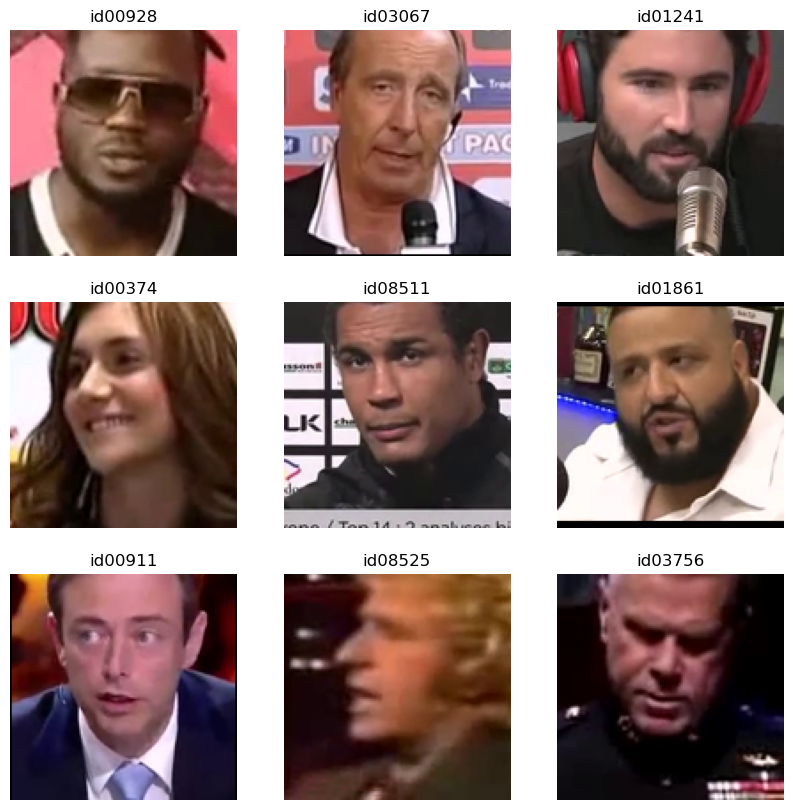

In [10]:
class_names = training_set.class_names
#print(class_names)
plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
# Normalize pixel values between 0 and 1
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [101]:
# Define input shape and latent dimension
latent_dim = 2
input_shape = (img_size, img_size, 3)
# Encoder network
inputs = Input(shape=input_shape)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(8, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)
x = Conv2D(1, (3, 3), activation='relu', padding='same')(x)
shape_before_flattening = K.int_shape(x)
x = Flatten()(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

In [102]:
shape_before_flattening

(None, 64, 64, 1)

In [103]:
# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Reparameterization trick
z = Lambda(sampling)([z_mean, z_log_var])

In [104]:
# Decoder network
decoder_input = Input(K.int_shape(z)[1:])
x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = Reshape(shape_before_flattening[1:])(x)
x = Conv2DTranspose(128, (2, 2), activation='relu', padding='same', )(x)
x = Conv2DTranspose(64, (2, 2), activation='relu', padding='same', strides=(2, 2))(x)
x = Conv2DTranspose(32, (2, 2), activation='relu', padding='same', )(x)
x = Conv2DTranspose(16, (2, 2), activation='relu', padding='same', )(x)
x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [105]:
num_features = shape_before_flattening[1] * shape_before_flattening[2] * shape_before_flattening[3]


In [106]:
num_features

4096

In [107]:
# Define the VAE model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, x, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

In [108]:
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 encoder (Functional)        [(None, 2),               18069     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 128, 128, 3)       56483     
                                                                 
Total params: 74,552
Trainable params: 74,552
Non-trainable params: 0
_________________________________________________________________


In [109]:
tf.keras.utils.plot_model(vae,"model.png", show_shapes = True,)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [110]:
# Define the VAE loss function
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=1)
B = 1000   
vae_loss = K.mean(B * reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [111]:
vae.add_metric(kl_loss, name="kl_loss")
vae.add_metric(reconstruction_loss, name="reconstruction_loss")

In [112]:
vae.compile(optimizer='adam')
vae.fit(x_train, epochs=5000, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/5000


1/1 [==============================] - 4s 4s/step - loss: 3891430.7500 - kl_loss: 7.0989e-05 - reconstruction_loss: 3891.4307 - val_loss: 4278264.5000 - val_kl_loss: 1.7532e-04 - val_reconstruction_loss: 4278.2646
Epoch 2/5000
1/1 [==============================] - 0s 39ms/step - loss: 3867229.5000 - kl_loss: 3.5286e-05 - reconstruction_loss: 3867.2295 - val_loss: 4259477.0000 - val_kl_loss: 3.6369e-04 - val_reconstruction_loss: 4259.4771
Epoch 3/5000
1/1 [==============================] - 0s 39ms/step - loss: 3844049.7500 - kl_loss: 1.2892e-04 - reconstruction_loss: 3844.0498 - val_loss: 4236111.5000 - val_kl_loss: 6.8660e-04 - val_reconstruction_loss: 4236.1113
Epoch 4/5000
1/1 [==============================] - 0s 40ms/step - loss: 3809899.5000 - kl_loss: 3.0935e-04 - reconstruction_loss: 3809.8994 - val_loss: 4208150.5000 - val_kl_loss: 0.0013 - val_reconstruction_loss: 4208.1504
Epoch 5/5000
1/1 [==============================] - 0s 40ms/step - loss: 3769820.2500 - kl_loss: 6.5434

KeyboardInterrupt: 

1/1 [==============================] - 0s 31ms/step


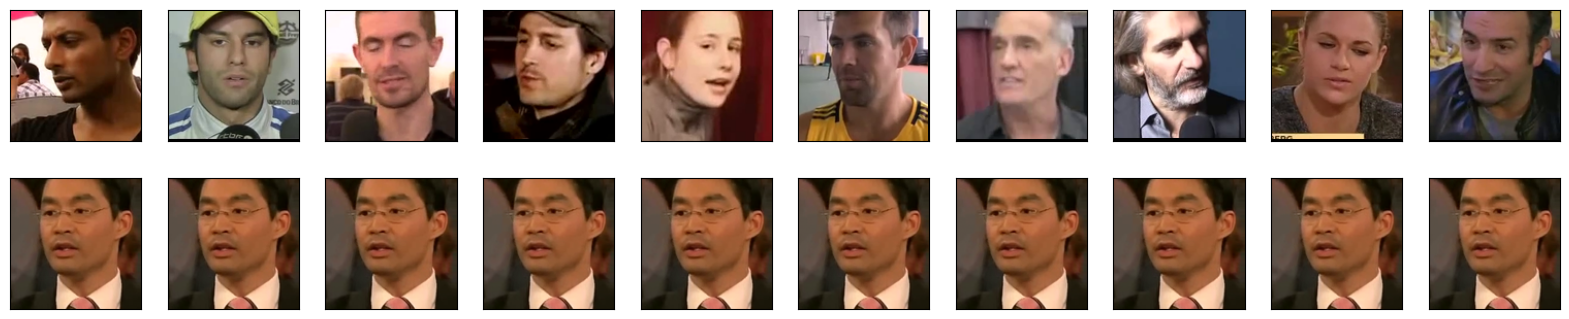

In [ ]:
import matplotlib.pyplot as plt
# Convert the predictions into images
decoded_imgs = vae.predict(x_test)
# Display the original and reconstructed images
n = 10 # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display the original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(img_size, img_size,3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display the reconstructed image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(img_size, img_size,3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()